<font size='+1' color=red>**Attention:**</font> Data cleaning and other parts of preprocessing of data which we covered in the first assignment, is not neccesary all the time but you may need some of them according to task at hand. So we don't explicitly mention them each time. This is your job to figure out when to apply them.

<font size='+1' color=red>**Attention 2:**</font> For your implementations always use `random_state=42` so your code would be reproducible.

## <font color='#D61E85' size='+3'>**Q1:**</font> <font size='+2'> **PCA for Classification** </font>

In this question we want to work with the Fashion-MNIST dataset. Fashion-MNIST is a dataset comprising of $28 \times 28$ grayscale images of $70,000$ fashion products from $10$ categories, with $7,000$ images per category. The training set has $60,000$ images and the test set has $10,000$ images. <br>
<font color=red>**Note:**</font> You can download it from any source you want. <br>
<font color=red>**Note:**</font> Take first $60,000$ instances of it as the train and the $10,000$ remaining instances as the test set.

Using explained varinace ratio and considering a threshold like $95\%$ you probably know how to choose the right number of dimensions to perform PCA. But, when you are using dimensionality reduction as a preprocessing step for a supervised learning task, it is important to consider the impact of the optimal number of dimensions on the overall performance of the model. Consider the classification task using the dataset at hand. Try to find the best number of components for the PCA with respect to the task. You should use the `RandomForestClassifier`, `KNeighborsClassifier`, `DecisionTreeClassifier`, and `AdaBoostClassifier`. Compare your results (number of dimensions, accuracy, precision, recall, f1-score, and confusion matrix) and explain why the number of dimensions for different models are different. Don't forget to analyze your results. [Hint: you should try to make a pipeline and try to tune the hyperparameters of PCA and your model adjointly.]

At the end, perform the hyperparameter tuning but this time without considering the PCA preprocessing step. Compare your results with previous ones.

<font color='#8FCF26' size='+2'>**A1:**</font> Your explanations

**Import Libraries**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, make_scorer, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml

In this step, we load Fashion-MNIST dataset and normalize examples in dataset. To normalize images, we divide each pixel value by 255 to have pixel values in range [0,1]:

In [ ]:
# Load the Fashion-MNIST dataset
fashion_mnist = fetch_openml(name='Fashion-MNIST')
X, y = fashion_mnist.data.astype('float32')/255.0, fashion_mnist.target.astype('int')

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


This dataset contains 70000 instances of $28 × 28$ images:

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Columns: 784 entries, pixel1 to pixel784
dtypes: float64(784)
memory usage: 418.7 MB


We specify 60000 examples to the train and 10000 examples to the test:

In [ ]:
# Train and Test sets
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Here we define different classifiers to utilize them in next steps:

In [ ]:
# Define the classifiers
classifiers = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'KNeighbors': KNeighborsClassifier(),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42)
}

Instead of determining exact number of components, we define the portion of variance that our model should cover:

In [ ]:
# Define PCA parameters for searching
param_grid_pca = {
    'pca__n_components': [0.98, 0.95, 0.90],
}

Also for all of the classifiers, special parameters for searching are defined:

In [ ]:
param_grids = {
    'RandomForest': {'clf__n_estimators': [50, 100, 150]},
    'KNeighbors': {'clf__n_neighbors': [3, 5, 7]},
    'DecisionTree': {'clf__max_depth': [None, 10, 20]},
    'AdaBoost': {'clf__n_estimators': [50, 100, 200], 'clf__learning_rate': [0.01, 0.1, 1.0]}
}

Time to search for optimal parameters!

## RandomForest

The first step for every model will be building the pipeline:

In [ ]:
# Create the pipeline with PCA and classifier
pipeline = Pipeline([
        ('pca', PCA(random_state=42)),
        ('clf', classifiers['RandomForest'])
        ])

Then we prepare parameters for searching:

In [ ]:
param_grid = {}
param_grid.update(param_grid_pca)
param_grid.update(param_grids['RandomForest'])

Because we want to find optimal parameters for both PCA and classifier and this process is really time-consuming, we will use Randomized Search to make this process faster. The metric that we will use to evaluate our models is F1-micro.

The optimal parametrs for RandomForest are shown in the below. It is interesting the value of 0.9 for variance has given use better results:

In [ ]:
# Create the random search
grid_search = RandomizedSearchCV(pipeline, param_grid, n_iter=5, scoring='f1_micro', n_jobs=-1, random_state=42)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_search.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_search.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_search.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 Pipeline(steps=[('pca', PCA(n_components=0.9, random_state=42)),
                ('clf',
                 RandomForestClassifier(n_estimators=150, random_state=42))])

 The best score across ALL searched params:
 0.8682333333333334

 The best parameters across ALL searched params:
 {'pca__n_components': 0.9, 'clf__n_estimators': 150}


The portion of variance that we obtained corresponds to 84 components. We also have good results on the test set:

In [ ]:
# Evaluate on the test set
y_pred = best_model.predict(X_test)

print(f"Best number of dimensions for RandomForest: {best_model.named_steps['pca'].n_components_}")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred, average='micro')}")
print(f"Recall: {recall_score(y_test, y_pred, average='micro')}")
print(f"F1 Score: {f1_score(y_test, y_pred, average='micro')}")

Best number of dimensions for RandomForest: 84
Accuracy: 0.8608
Precision: 0.8608
Recall: 0.8608
F1 Score: 0.8607999999999999


Most of the classes are predicted correctly but among them "label 6" has the most mispredicted examples; They mostly predicted with labels "0", "2" and "4":

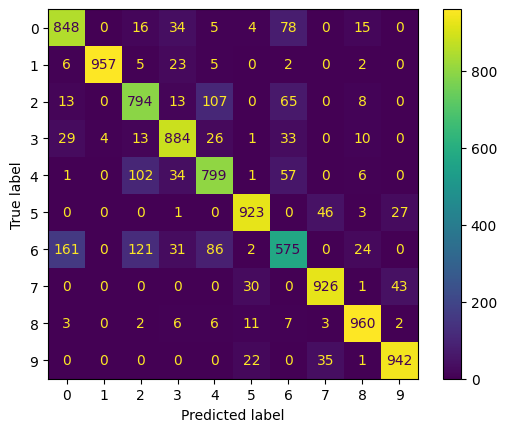

In [ ]:
cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot()

## KNN

In [ ]:
# Create the pipeline with PCA and classifier
pipeline = Pipeline([
        ('pca', PCA(random_state=42)),
        ('clf', classifiers['KNeighbors'])
        ])

In [ ]:
param_grid = {}
param_grid.update(param_grid_pca)
param_grid.update(param_grids['KNeighbors'])

The performance of KNN model on the train set is approximately as well as RandomForest. Comparing with RandomForest, here KNN needed more portion of variance:

In [ ]:
# Create the random search
rand_search_knn = RandomizedSearchCV(pipeline, param_grid, n_iter=5, scoring='f1_micro', n_jobs=-1, random_state=42)

# Fit the model
rand_search_knn.fit(X_train, y_train)

# Get the best model
best_model_knn = rand_search_knn.best_estimator_

print(" Results from Random Search " )
print("\n The best estimator across ALL searched params:\n",rand_search_knn.best_estimator_)
print("\n The best score across ALL searched params:\n",rand_search_knn.best_score_)
print("\n The best parameters across ALL searched params:\n",rand_search_knn.best_params_)

 Results from Random Search 

 The best estimator across ALL searched params:
 Pipeline(steps=[('pca', PCA(n_components=0.95, random_state=42)),
                ('clf', KNeighborsClassifier(n_neighbors=7))])

 The best score across ALL searched params:
 0.8624499999999999

 The best parameters across ALL searched params:
 {'pca__n_components': 0.95, 'clf__n_neighbors': 7}


The optimal number of components is 187 and again we have also a good performance on the test set:

In [ ]:
# Evaluate on the test set
y_pred = best_model_knn.predict(X_test)

print(f"Best number of dimensions for KNN: {best_model_knn.named_steps['pca'].n_components_}")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred, average='micro')}")
print(f"Recall: {recall_score(y_test, y_pred, average='micro')}")
print(f"F1 Score: {f1_score(y_test, y_pred, average='micro')}")

Best number of dimensions for KNN: 187
Accuracy: 0.8619
Precision: 0.8619
Recall: 0.8619
F1 Score: 0.8619


The confusion matrix for KNN is like RandomForest. Again "label 6" has the most mispredicted examples:

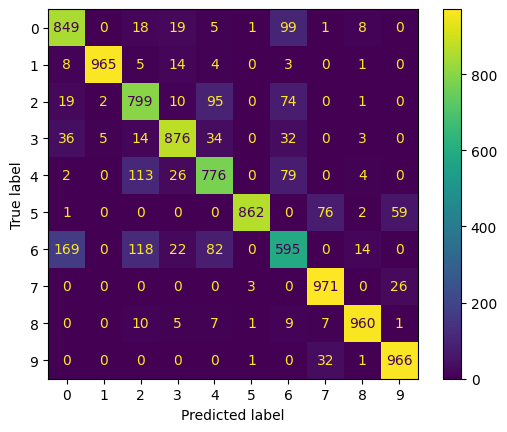

In [ ]:
cm = confusion_matrix(y_test, y_pred, labels=best_model_knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model_knn.classes_)
disp.plot()

## DecisionTree

In [ ]:
# Create the pipeline with PCA and classifier
pipeline = Pipeline([
        ('pca', PCA(random_state=42)),
        ('clf', classifiers['DecisionTree'])
        ])

In [ ]:
param_grid = {}
param_grid.update(param_grid_pca)
param_grid.update(param_grids['DecisionTree'])

The performance of decision tree on the training set is worse than KNN and RandomForest but not too much. Decision tree is same as RandomForest in portion of variance:

In [ ]:
# Create the random search
rand_search_tree = RandomizedSearchCV(pipeline, param_grid, n_iter=5, scoring='f1_micro', n_jobs=-1, random_state=42)

# Fit the model
rand_search_tree.fit(X_train, y_train)

# Get the best model
best_model_tree = rand_search_tree.best_estimator_

print(" Results from Random Search " )
print("\n The best estimator across ALL searched params:\n",rand_search_tree.best_estimator_)
print("\n The best score across ALL searched params:\n",rand_search_tree.best_score_)
print("\n The best parameters across ALL searched params:\n",rand_search_tree.best_params_)

 Results from Random Search 

 The best estimator across ALL searched params:
 Pipeline(steps=[('pca', PCA(n_components=0.9, random_state=42)),
                ('clf', DecisionTreeClassifier(max_depth=20, random_state=42))])

 The best score across ALL searched params:
 0.7721333333333333

 The best parameters across ALL searched params:
 {'pca__n_components': 0.9, 'clf__max_depth': 20}


The optimal number of components is 84. According to the results we had on the training set, we have a good performance on the test set:

In [ ]:
# Evaluate on the test set
y_pred = best_model_tree.predict(X_test)

print(f"Best number of dimensions for DecisionTree: {best_model_tree.named_steps['pca'].n_components_}")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred, average='micro')}")
print(f"Recall: {recall_score(y_test, y_pred, average='micro')}")
print(f"F1 Score: {f1_score(y_test, y_pred, average='micro')}")

Best number of dimensions for DecisionTree: 84
Accuracy: 0.7755
Precision: 0.7755
Recall: 0.7755
F1 Score: 0.7755


In this scenario, in addition to "label 6" that again has the most wrong predictions, "label 2" and "label 4" have a noticeable number of mispredictions:

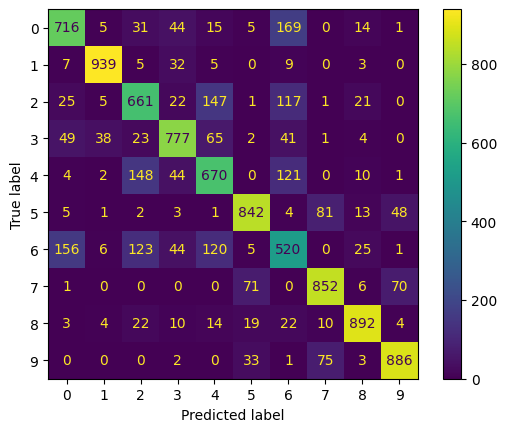

In [ ]:
cm = confusion_matrix(y_test, y_pred, labels=best_model_tree.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model_tree.classes_)
disp.plot()

## AdaBoost

In [ ]:
# Create the pipeline with PCA and classifier
pipeline = Pipeline([
        ('pca', PCA(random_state=42)),
        ('clf', classifiers['AdaBoost'])
        ])

In [ ]:
param_grid = {}
param_grid.update(param_grid_pca)
param_grid.update(param_grids['AdaBoost'])

AdaBoost has the worst performance among different models. The portion of pca is 0.95:

In [ ]:
# Create the grid search
rand_search_ada = RandomizedSearchCV(pipeline, param_grid, n_iter=5, scoring='f1_micro', n_jobs=-1, random_state=42)

# Fit the model
rand_search_ada.fit(X_train, y_train)

# Get the best model
best_model_ada = rand_search_ada.best_estimator_

print(" Results from Random Search " )
print("\n The best estimator across ALL searched params:\n",rand_search_ada.best_estimator_)
print("\n The best score across ALL searched params:\n",rand_search_ada.best_score_)
print("\n The best parameters across ALL searched params:\n",rand_search_ada.best_params_)

 Results from Random Search 

 The best estimator across ALL searched params:
 Pipeline(steps=[('pca', PCA(n_components=0.95, random_state=42)),
                ('clf',
                 AdaBoostClassifier(learning_rate=0.1, n_estimators=100,
                                    random_state=42))])

 The best score across ALL searched params:
 0.5644666666666666

 The best parameters across ALL searched params:
 {'pca__n_components': 0.95, 'clf__n_estimators': 100, 'clf__learning_rate': 0.1}


The number of PCA componets is 187. The performance on the test set is not promising:

In [ ]:
# Evaluate on the test set
y_pred = best_model_ada.predict(X_test)

print(f"Best number of dimensions for AdaBoost: {best_model_ada.named_steps['pca'].n_components_}")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred, average='micro')}")
print(f"Recall: {recall_score(y_test, y_pred, average='micro')}")
print(f"F1 Score: {f1_score(y_test, y_pred, average='micro')}")

Best number of dimensions for AdaBoost: 187
Accuracy: 0.5579
Precision: 0.5579
Recall: 0.5579
F1 Score: 0.5579


"Label 1" has the worst condition! Almost all of the examples with label mispredicted as "label 3":

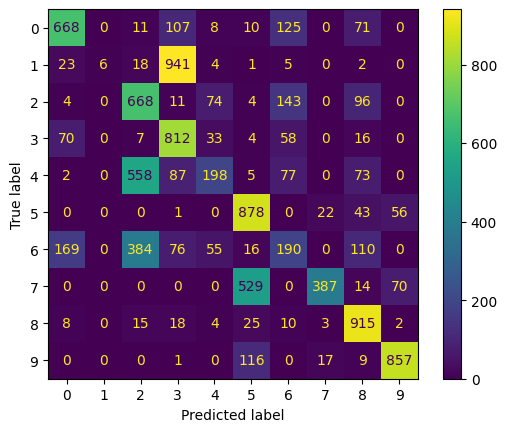

In [ ]:
cm = confusion_matrix(y_test, y_pred, labels=best_model_ada.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model_ada.classes_)
disp.plot()

Now this question:

**Why the number of dimensions for different models are different?**

The number of principal components (dimensions) retained after applying PCA can vary for different classifiers because each classifier has its own characteristics and requirements. The optimal number of components for PCA depends on the underlying structure and complexity of the data as well as the specific characteristics of the classifier. Here are some reasons why the number of dimensions might differ for different models:

1. **Data Structure and Variability:**
   - The inherent structure and variability in your data might be captured differently by various classifiers. Some classifiers may require fewer dimensions to effectively represent the data, while others might benefit from a higher-dimensional representation.

2. **Model Sensitivity to Feature Space:**
   - Different classifiers have varying degrees of sensitivity to the feature space. Some models, like decision trees, may be able to capture complex relationships in a lower-dimensional space, while others, like k-nearest neighbors (KNN), might require a higher-dimensional representation to perform well.

3. **Hyperparameter Tuning:**
   - The hyperparameters of each classifier, such as the number of trees in a Random Forest or the number of neighbors in KNN, can influence the optimal number of principal components. Tuning these hyperparameters in combination with PCA can lead to different dimensionalities for different models.

## Tuning just classifier parameters

Now it's time to tune our classifiers without PCA:

## Random Forest

We build the pipeline just with classifier:

In [ ]:
# Create the pipeline with PCA and classifier
pipeline = Pipeline([
        ('clf', classifiers['RandomForest'])
        ])

In [ ]:
param_grid = param_grids['RandomForest']

Here because we have less parameters for searching, we use GridSearch

The results are interesting. We achieved a better performance without PCA but it is slightly better. The number of estimators is same as the pipeline with PCA:

In [ ]:
# Create the grid search
grid_search_forest = GridSearchCV(pipeline, param_grid, scoring='f1_micro', n_jobs=-1)

# Fit the model
grid_search_forest.fit(X_train, y_train)

# Get the best model
best_model_forest = grid_search_forest.best_estimator_

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_search_forest.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_search_forest.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_search_forest.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 Pipeline(steps=[('clf',
                 RandomForestClassifier(n_estimators=150, random_state=42))])

 The best score across ALL searched params:
 0.8839833333333333

 The best parameters across ALL searched params:
 {'clf__n_estimators': 150}


We also have better performance on the test set:

In [ ]:
# Evaluate on the test set
y_pred = best_model_forest.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred, average='micro')}")
print(f"Recall: {recall_score(y_test, y_pred, average='micro')}")
print(f"F1 Score: {f1_score(y_test, y_pred, average='micro')}")

Accuracy: 0.8783
Precision: 0.8783
Recall: 0.8783
F1 Score: 0.8783


We again have "label 6" problem in here but now we have more correct predictions:

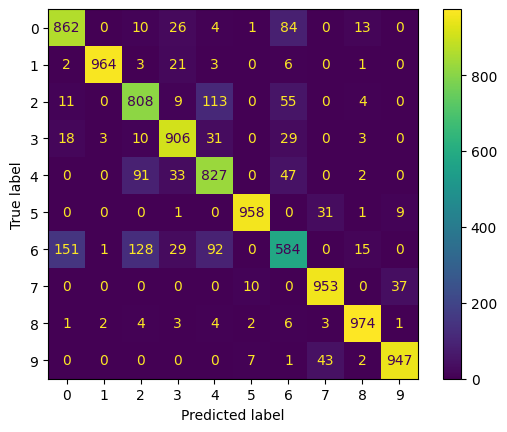

In [ ]:
cm = confusion_matrix(y_test, y_pred, labels=best_model_forest.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model_forest.classes_)
disp.plot()

## KNN

In [ ]:
pipeline = Pipeline([
        ('clf', classifiers['KNeighbors'])
        ])

In [ ]:
param_grid = param_grids['KNeighbors']

KNN without PCA is a little worse but not too much. The number of neighbors is 5 while in the last case was 7:

In [ ]:
# Create the grid search
grid_search_knn_clf = GridSearchCV(pipeline, param_grid, scoring='f1_micro', n_jobs=-1)

# Fit the model
grid_search_knn_clf.fit(X_train, y_train)

# Get the best model
best_model_knn_clf = grid_search_knn_clf.best_estimator_

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_search_knn_clf.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_search_knn_clf.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_search_knn_clf.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 Pipeline(steps=[('clf', KNeighborsClassifier())])

 The best score across ALL searched params:
 0.8540000000000001

 The best parameters across ALL searched params:
 {'clf__n_neighbors': 5}


Same condition on the test set! good performance but worse than the pipeline with PCA:

In [ ]:
# Evaluate on the test set
y_pred = best_model_knn_clf.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred, average='micro')}")
print(f"Recall: {recall_score(y_test, y_pred, average='micro')}")
print(f"F1 Score: {f1_score(y_test, y_pred, average='micro')}")

Accuracy: 0.8554
Precision: 0.8554
Recall: 0.8554
F1 Score: 0.8554


We see "label 6" again!

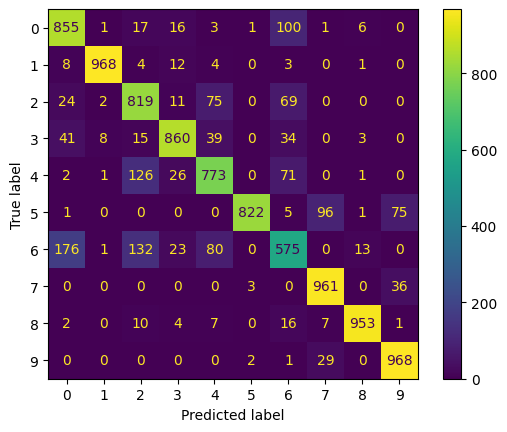

In [ ]:
cm = confusion_matrix(y_test, y_pred, labels=best_model_knn_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model_knn_clf.classes_)
disp.plot()

## DecisionTree

In [ ]:
pipeline = Pipeline([
        ('clf', classifiers['DecisionTree'])
        ])

In [ ]:
param_grid = param_grids['DecisionTree']

Desicuon tree performed better without PCA! Here the max depth is 10 while in the previous model was 20:

In [ ]:
# Create the grid search
grid_search_tree_clf = GridSearchCV(pipeline, param_grid, scoring='f1_micro', n_jobs=-1)

# Fit the model
grid_search_tree_clf.fit(X_train, y_train)

# Get the best model
best_model_tree_clf = grid_search_tree_clf.best_estimator_

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_search_tree_clf.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_search_tree_clf.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_search_tree_clf.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 Pipeline(steps=[('clf', DecisionTreeClassifier(max_depth=10, random_state=42))])

 The best score across ALL searched params:
 0.8072166666666668

 The best parameters across ALL searched params:
 {'clf__max_depth': 10}


good performance on the test set:

In [ ]:
# Evaluate on the test set
y_pred = best_model_tree_clf.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred, average='micro')}")
print(f"Recall: {recall_score(y_test, y_pred, average='micro')}")
print(f"F1 Score: {f1_score(y_test, y_pred, average='micro')}")

Accuracy: 0.8008
Precision: 0.8008
Recall: 0.8008
F1 Score: 0.8008


In addition to "label 6", "label 2" has many mispredictions:

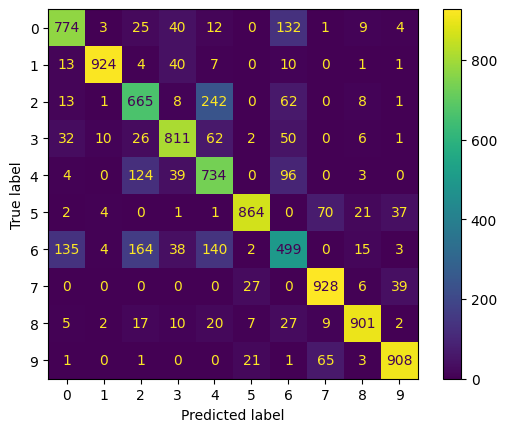

In [ ]:
cm = confusion_matrix(y_test, y_pred, labels=best_model_tree_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model_tree_clf.classes_)
disp.plot()

## AdaBoost

In [ ]:
pipeline = Pipeline([
        ('clf', classifiers['AdaBoost'])
        ])

In [ ]:
param_grid = param_grids['AdaBoost']

AdaBoost performed a little better without PCA but still it is not so good. The number of estimators increased to 200:

In [ ]:
# Create the grid search
grid_search_ada_clf = GridSearchCV(pipeline, param_grid, scoring='f1_micro', n_jobs=-1)

# Fit the model
grid_search_ada_clf.fit(X_train, y_train)

# Get the best model
best_model_ada_clf = grid_search_ada_clf.best_estimator_

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_search_ada_clf.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_search_ada_clf.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_search_ada_clf.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 Pipeline(steps=[('clf',
                 AdaBoostClassifier(learning_rate=0.1, n_estimators=200,
                                    random_state=42))])

 The best score across ALL searched params:
 0.5954499999999999

 The best parameters across ALL searched params:
 {'clf__learning_rate': 0.1, 'clf__n_estimators': 200}


The performance on the test is a little better than the last model:

In [ ]:
# Evaluate on the test set
y_pred = best_model_ada_clf.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred, average='micro')}")
print(f"Recall: {recall_score(y_test, y_pred, average='micro')}")
print(f"F1 Score: {f1_score(y_test, y_pred, average='micro')}")

Accuracy: 0.5702
Precision: 0.5702
Recall: 0.5702
F1 Score: 0.5702


We have problem with "label 0" in here. A lot of intances of this class are classified with "label 6":

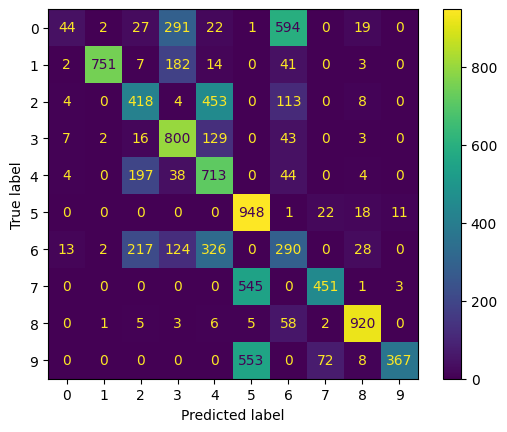

In [ ]:
cm = confusion_matrix(y_test, y_pred, labels=best_model_ada_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model_ada_clf.classes_)
disp.plot()

## <font color='#D61E85' size='+3'>**Q2:**</font> <font size='+2'> **Randomized PCA** </font>

In this question we want to check the time complexity of finding an approximation of the first $d$ principal components. Also, we want to see how is the performance of it in compare to the original PCA. In order to make this happen there is a stochastic algorithm called *randomized PCA* which has a faster procedure to find the first $d$ principal components.

By default, the `svd_solver` parameter of PCA in Scikit-learn is set to `"auto"`. It means that it automatically determine to use `"full"` or `"randomized"` to find the principal components. Base on our text book:

"Scikit-learn uses the randomized PCA algorithm if $max(m, n) > 500$ and `n_components` is an integer smaller than $80\%$ of $min(m,n)$, or else it uses the full SVD approach"

<font size='+1'>**(a)**</font> For previous question you found $d$ components for each one of the classifiers.This time try to perform PCA without considering the classifier and just by determining the number of components. For the `svd_solver`, this time use both `"full"` and `"randomized"` arguments separately and compare the results of them. Also compare the running time of `"full"` and `"randomized"` for each one of the classifiers. Explain your observations. You should perform following steps one-by-one for each classifier:

*   Perform PCA for both `"full"` and `"randomized"`. Repoert the time of performing them.

*   For both cases fit the new training data (after dimensionality reduction) to the classifier. Then report the results (Accuracy, F1-score, ...) on test set.

<font size='+1'>**(b)**</font> This time consider the $d=10$ and compare the running times for both `"full"` and `"randomized"` arguments. Explain your observations.

<font size='+1'>**(c)**</font> There is something called Incremental PCA (IPCA), explain what is it and in what situations it is useful?

<font size='+1'>**(d)**</font> Consider the number of batches equal to $200$ and perform the IPCA.

<font color='#8FCF26' size='+2'>**A2:**</font> Your explanations

<font color='#FCA26' size='+2'>**(a):**</font>

In [69]:
# Your code
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, make_scorer, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.decomposition import IncrementalPCA
import time

In [2]:
# Load the Fashion-MNIST dataset
fashion_mnist = fetch_openml(name='Fashion-MNIST')
X, y = fashion_mnist.data.astype('float32')/255.0, fashion_mnist.target.astype('int')

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [15]:
# Train and Test sets
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

At first we determine the number of components that we obtained from the last part:

In [4]:
rf_comp = 84
knn_comp = 187
dectree_comp = 84
ada_comp = 187

## RandomForest

Not just in this case but in all of the following cases we will see that full PCA wil need more time than Randomized PCA. It is faster because Its computational complexity is $O(m × d^2 ) + O(d^3 )$,instead of $O(m × n^2 ) + O(n^3 )$ for the full SVD approach, so it is dramatically faster than full SVD when d is much smaller than n:

In [35]:
# Full PCA
pca_full = PCA(n_components=rf_comp, svd_solver="full")
start_time_full = time.time()
X_train_pca_full = pca_full.fit_transform(X_train)
end_time_full = time.time()
print("Time for Full PCA:", end_time_full - start_time_full)

Time for Full PCA: 13.423475503921509


In [36]:
X_test_pca_full = pca_full.transform(X_test)

In [37]:
# Randomized PCA
pca_rand = PCA(n_components=rf_comp, svd_solver="randomized")
start_time_rand = time.time()
X_train_pca_rand = pca_rand.fit_transform(X_train)
end_time_rand = time.time()
print("Time for Randomized PCA:", end_time_rand - start_time_rand)

Time for Randomized PCA: 8.280904054641724


In [38]:
X_test_pca_rand = pca_rand.transform(X_test)

Now we evaluate both models: one with data of full PCA and another with randomized PCA data. Both models scored the highest on the training set but on the test set,the model with randomized PCA had a little better performance:

In [39]:
# Train with full pca data
rf = RandomForestClassifier(n_estimators=150, random_state=42)
rf.fit(X_train_pca_full, y_train)

# Evaluate on the train set
y_pred = rf.predict(X_train_pca_full)

print("Results on Training Data:")
print(f"Accuracy: {accuracy_score(y_train, y_pred)}")
print(f"Precision: {precision_score(y_train, y_pred, average='micro')}")
print(f"Recall: {recall_score(y_train, y_pred, average='micro')}")
print(f"F1 Score: {f1_score(y_train, y_pred, average='micro')}")

Results on Training Data:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


In [40]:
# Evaluate on the test set
y_pred = rf.predict(X_test_pca_full)

print("Results on Test Data:")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred, average='micro')}")
print(f"Recall: {recall_score(y_test, y_pred, average='micro')}")
print(f"F1 Score: {f1_score(y_test, y_pred, average='micro')}")

Results on Test Data:
Accuracy: 0.8608
Precision: 0.8608
Recall: 0.8608
F1 Score: 0.8607999999999999


In [41]:
# Train with randomized pca data
rf = RandomForestClassifier(n_estimators=150, random_state=42)
rf.fit(X_train_pca_rand, y_train)

# Evaluate on the train set
y_pred = rf.predict(X_train_pca_rand)

print("Results on Training Data:")
print(f"Accuracy: {accuracy_score(y_train, y_pred)}")
print(f"Precision: {precision_score(y_train, y_pred, average='micro')}")
print(f"Recall: {recall_score(y_train, y_pred, average='micro')}")
print(f"F1 Score: {f1_score(y_train, y_pred, average='micro')}")

Results on Training Data:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


In [42]:
# Evaluate on the test set
y_pred = rf.predict(X_test_pca_rand)

print("Results on Test Data:")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred, average='micro')}")
print(f"Recall: {recall_score(y_test, y_pred, average='micro')}")
print(f"F1 Score: {f1_score(y_test, y_pred, average='micro')}")

Results on Test Data:
Accuracy: 0.865
Precision: 0.865
Recall: 0.865
F1 Score: 0.865


## KNN

In [43]:
# Full PCA
pca_full = PCA(n_components=knn_comp, svd_solver="full")
start_time_full = time.time()
X_train_pca_full = pca_full.fit_transform(X_train)
end_time_full = time.time()
print("Time for Full PCA:", end_time_full - start_time_full)

Time for Full PCA: 12.783546209335327


In [44]:
X_test_pca_full = pca_full.transform(X_test)

In [45]:
# Randomized PCA
pca_rand = PCA(n_components=knn_comp, svd_solver="randomized")
start_time_rand = time.time()
X_train_pca_rand = pca_rand.fit_transform(X_train)
end_time_rand = time.time()
print("Time for Randomized PCA:", end_time_rand - start_time_rand)

Time for Randomized PCA: 11.8432035446167


In [46]:
X_test_pca_rand = pca_rand.transform(X_test)

For KNN, we don't observe severe changes on the performance, either on the training set or test, Full and randomized PCA have close results:

In [47]:
# Train with full pca data
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train_pca_full, y_train)

# Evaluate on the train set
y_pred = knn.predict(X_train_pca_full)

print("Results on Training Data:")
print(f"Accuracy: {accuracy_score(y_train, y_pred)}")
print(f"Precision: {precision_score(y_train, y_pred, average='micro')}")
print(f"Recall: {recall_score(y_train, y_pred, average='micro')}")
print(f"F1 Score: {f1_score(y_train, y_pred, average='micro')}")

Results on Training Data:
Accuracy: 0.8951666666666667
Precision: 0.8951666666666667
Recall: 0.8951666666666667
F1 Score: 0.8951666666666667


In [48]:
# Evaluate on the test set
y_pred = knn.predict(X_test_pca_full)

print("Results on Test Data:")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred, average='micro')}")
print(f"Recall: {recall_score(y_test, y_pred, average='micro')}")
print(f"F1 Score: {f1_score(y_test, y_pred, average='micro')}")

Results on Test Data:
Accuracy: 0.8619
Precision: 0.8619
Recall: 0.8619
F1 Score: 0.8619


In [49]:
# Train with randomized pca data
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train_pca_rand, y_train)

# Evaluate on the train set
y_pred = knn.predict(X_train_pca_rand)

print("Results on Training Data:")
print(f"Accuracy: {accuracy_score(y_train, y_pred)}")
print(f"Precision: {precision_score(y_train, y_pred, average='micro')}")
print(f"Recall: {recall_score(y_train, y_pred, average='micro')}")
print(f"F1 Score: {f1_score(y_train, y_pred, average='micro')}")

Results on Training Data:
Accuracy: 0.8956666666666667
Precision: 0.8956666666666667
Recall: 0.8956666666666667
F1 Score: 0.8956666666666667


In [50]:
# Evaluate on the test set
y_pred = knn.predict(X_test_pca_rand)

print("Results on Test Data:")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred, average='micro')}")
print(f"Recall: {recall_score(y_test, y_pred, average='micro')}")
print(f"F1 Score: {f1_score(y_test, y_pred, average='micro')}")

Results on Test Data:
Accuracy: 0.8615
Precision: 0.8615
Recall: 0.8615
F1 Score: 0.8615


## Decision Tree

In [51]:
# Full PCA
pca_full = PCA(n_components=dectree_comp, svd_solver="full")
start_time_full = time.time()
X_train_pca_full = pca_full.fit_transform(X_train)
end_time_full = time.time()
print("Time for Full PCA:", end_time_full - start_time_full)

Time for Full PCA: 18.019317150115967


In [52]:
X_test_pca_full = pca_full.transform(X_test)

In [53]:
# Randomized PCA
pca_rand = PCA(n_components=dectree_comp, svd_solver="randomized")
start_time_rand = time.time()
X_train_pca_rand = pca_rand.fit_transform(X_train)
end_time_rand = time.time()
print("Time for Randomized PCA:", end_time_rand - start_time_rand)

Time for Randomized PCA: 8.455098390579224


In [54]:
X_test_pca_rand = pca_rand.transform(X_test)

We have same condition like KNN; The results are too close:

In [55]:
# Train with full pca data
tree = DecisionTreeClassifier(max_depth=20, random_state=42)
tree.fit(X_train_pca_full, y_train)

# Evaluate on the train set
y_pred = tree.predict(X_train_pca_full)

print("Results on Training Data:")
print(f"Accuracy: {accuracy_score(y_train, y_pred)}")
print(f"Precision: {precision_score(y_train, y_pred, average='micro')}")
print(f"Recall: {recall_score(y_train, y_pred, average='micro')}")
print(f"F1 Score: {f1_score(y_train, y_pred, average='micro')}")

Results on Training Data:
Accuracy: 0.9789833333333333
Precision: 0.9789833333333333
Recall: 0.9789833333333333
F1 Score: 0.9789833333333333


In [56]:
# Evaluate on the test set
y_pred = tree.predict(X_test_pca_full)

print("Results on Test Data:")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred, average='micro')}")
print(f"Recall: {recall_score(y_test, y_pred, average='micro')}")
print(f"F1 Score: {f1_score(y_test, y_pred, average='micro')}")

Results on Test Data:
Accuracy: 0.7755
Precision: 0.7755
Recall: 0.7755
F1 Score: 0.7755


In [57]:
# Train with randomized pca data
tree = DecisionTreeClassifier(max_depth=20, random_state=42)
tree.fit(X_train_pca_rand, y_train)

# Evaluate on the train set
y_pred = tree.predict(X_train_pca_rand)

print("Results on Training Data:")
print(f"Accuracy: {accuracy_score(y_train, y_pred)}")
print(f"Precision: {precision_score(y_train, y_pred, average='micro')}")
print(f"Recall: {recall_score(y_train, y_pred, average='micro')}")
print(f"F1 Score: {f1_score(y_train, y_pred, average='micro')}")

Results on Training Data:
Accuracy: 0.9786166666666667
Precision: 0.9786166666666667
Recall: 0.9786166666666667
F1 Score: 0.9786166666666667


In [58]:
# Evaluate on the test set
y_pred = tree.predict(X_test_pca_rand)

print("Results on Test Data:")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred, average='micro')}")
print(f"Recall: {recall_score(y_test, y_pred, average='micro')}")
print(f"F1 Score: {f1_score(y_test, y_pred, average='micro')}")

Results on Test Data:
Accuracy: 0.7753
Precision: 0.7753
Recall: 0.7753
F1 Score: 0.7753


## AdaBoost

In [59]:
# Full PCA
pca_full = PCA(n_components=ada_comp, svd_solver="full")
start_time_full = time.time()
X_train_pca_full = pca_full.fit_transform(X_train)
end_time_full = time.time()
print("Time for Full PCA:", end_time_full - start_time_full)

Time for Full PCA: 20.643507480621338


In [60]:
X_test_pca_full = pca_full.transform(X_test)

In [61]:
# Randomized PCA
pca_rand = PCA(n_components=ada_comp, svd_solver="randomized")
start_time_rand = time.time()
X_train_pca_rand = pca_rand.fit_transform(X_train)
end_time_rand = time.time()
print("Time for Randomized PCA:", end_time_rand - start_time_rand)

Time for Randomized PCA: 15.041625022888184


In [62]:
X_test_pca_rand = pca_rand.transform(X_test)

For both full and randomized PCA and either on the training or test set, the performance is the same:

In [63]:
# Train with full pca data
adaboost = AdaBoostClassifier(learning_rate=0.1, n_estimators=100, random_state=42)
adaboost.fit(X_train_pca_full, y_train)

# Evaluate on the train set
y_pred = adaboost.predict(X_train_pca_full)

print("Results on Training Data:")
print(f"Accuracy: {accuracy_score(y_train, y_pred)}")
print(f"Precision: {precision_score(y_train, y_pred, average='micro')}")
print(f"Recall: {recall_score(y_train, y_pred, average='micro')}")
print(f"F1 Score: {f1_score(y_train, y_pred, average='micro')}")

Results on Training Data:
Accuracy: 0.5660833333333334
Precision: 0.5660833333333334
Recall: 0.5660833333333334
F1 Score: 0.5660833333333334


In [64]:
# Evaluate on the test set
y_pred = adaboost.predict(X_test_pca_full)

print("Results on Test Data:")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred, average='micro')}")
print(f"Recall: {recall_score(y_test, y_pred, average='micro')}")
print(f"F1 Score: {f1_score(y_test, y_pred, average='micro')}")

Results on Test Data:
Accuracy: 0.5579
Precision: 0.5579
Recall: 0.5579
F1 Score: 0.5579


In [65]:
# Train with randomized pca data
adaboost = AdaBoostClassifier(learning_rate=0.1, n_estimators=100, random_state=42)
adaboost.fit(X_train_pca_rand, y_train)

# Evaluate on the train set
y_pred = adaboost.predict(X_train_pca_rand)

print("Results on Training Data:")
print(f"Accuracy: {accuracy_score(y_train, y_pred)}")
print(f"Precision: {precision_score(y_train, y_pred, average='micro')}")
print(f"Recall: {recall_score(y_train, y_pred, average='micro')}")
print(f"F1 Score: {f1_score(y_train, y_pred, average='micro')}")

Results on Training Data:
Accuracy: 0.5660833333333334
Precision: 0.5660833333333334
Recall: 0.5660833333333334
F1 Score: 0.5660833333333334


In [66]:
# Evaluate on the test set
y_pred = adaboost.predict(X_test_pca_rand)

print("Results on Test Data:")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred, average='micro')}")
print(f"Recall: {recall_score(y_test, y_pred, average='micro')}")
print(f"F1 Score: {f1_score(y_test, y_pred, average='micro')}")

Results on Test Data:
Accuracy: 0.5579
Precision: 0.5579
Recall: 0.5579
F1 Score: 0.5579


<font color='#FCA26' size='+2'>**(b):**</font>

In this part, number of components is much smaller than the dimension of original data so we see that a great difference between the time of full and ransomized PCA, Full PCA time is 4 times more than Randomized PCA. In other words, when we have $n<<d$, it's better to use randomized PCA:

In [67]:
# Full PCA
pca_full = PCA(n_components=10, svd_solver="full")
start_time_full = time.time()
X_train_pca_full = pca_full.fit_transform(X_train)
end_time_full = time.time()
print("Time for Full PCA:", end_time_full - start_time_full)

Time for Full PCA: 12.64909839630127


In [68]:
# Randomized PCA
pca_rand = PCA(n_components=10, svd_solver="randomized")
start_time_rand = time.time()
X_train_pca_rand = pca_rand.fit_transform(X_train)
end_time_rand = time.time()
print("Time for Randomized PCA:", end_time_rand - start_time_rand)

Time for Randomized PCA: 4.415503740310669


<font color='#FCA26' size='+2'>**(c):**</font>

One problem with the versions of PCA that we saw up to now is that they require the whole training set to fit in memory in order for the algorithm to run. Fortunately, incremental PCA (IPCA) algorithms have been developed that allow you to split the training set into mini-batches and feed these in one mini-batch at a time. This is useful for large training sets and for applying PCA online (i.e., on the fly, as new instances arrive).

<font color='#FCA26' size='+2'>**(d):**</font>

We can use incremental PCA in two different ways: using fit or partial_fit. When we use partial_fit, we manually split data batch by batch and feed it to the pca with fit let the model to divide data chunk by chunk based on number of batches:

In [70]:
# Number of batches
n_batches = 200

# Define IPCA with the desired number of components
ipca = IncrementalPCA(n_components=10, batch_size=n_batches)

# Fit IPCA on the training data
start_time_ipca = time.time()
X_train_ipca = ipca.fit_transform(X_train)
end_time_ipca = time.time()
print("Time for Incremental PCA:", end_time_ipca - start_time_ipca)

Time for Incremental PCA: 14.07972502708435


## <font color='#D61E85' size='+3'>**Q3:**</font> <font size='+2'> **Locally Linear Embedding** </font>

Locally linear embedding (LLE), is a nonlinear dimensionality reduction algorithm which is categorized as a manifold learning technique.

<font size='+1'>**(a)**</font> At first, try to explain how it works by mentioning its optimization objectives.

<font size='+1'>**(b)**</font> Now, it's time to implement it and trying to perform your implementation on a swiss roll to see what happens after unrolling. (try to plot your results)
The code below make you a swiss roll with $1000$ samples.

<font size='+1'>**(c)**</font> Finally use the LLE implementation provided by Scikit-learn to check the results of your implementation. (plot your results)

<font color='#8FCF26' size='+2'>**A3:**</font> Your explanations

**(a)**: Locally linear embedding (LLE) is a technique for reducing the complexity of data in a way that's different from other methods like PCA. It doesn't rely on projections. Instead, LLE looks at how each piece of data is connected to its closest neighbors and tries to find a simpler representation of the data where these connections stay intact. This makes LLE great at untangling twisted patterns, especially when there's not a lot of extra noise in the data.

Now it's time to see that how really LLE works: for each of the training examples $x^{(i)}$ the algorithm tries to find the k-nearest neighbors, then it will reproduce $x^{(i)}$ as a function of its neighbors. In other words, it aims to find $w_{i,j}$ in a way that the squared distance between $x^{(i)}$ and $\sum_{j=1}^{m} w_{i,j}x^{(j)}
$ has the minimum value when $w_{i,j}=0$ if $x^{(j)}$ is not one of k-nearest neighbors. With the following formula, We can find $W$ matrix with contanis the $w_{i,j}$ elements:

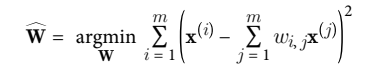

Also we want a normalization step to find to find weights of each training instance:

$w_{i,j}=0$
if $x^{(j)}$ is not one of knns of $x^{(i)}$.

$\sum_{j=1}^{m} w_{i,j} = 1
$
for $i=1,...,m$

Now we have local linear representations between all of the instances.

In the next step, we should map all examples on a d-dimensional space while the aim is to preserve the mentioned relations. $z^{(i)}$ is the image of $x^{(i)}$ in d-dimensional space and the thing we want to minimize is the squared distance between $z^{(i)}$ and $\sum_{j=1}^{m} w_{i,j}z^{(j)}$ when in this scenario we want to optimize $z$ not weight parameters. In the follwoing, you can see the formula for this step:

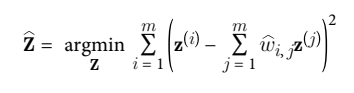

In [12]:
from sklearn.datasets import make_swiss_roll
import numpy as np
import matplotlib.pyplot as plt

X_swiss, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

To implement LLE, at first we need some helping functions. One of them is **calculate_nearest_neighbors**. It helps us to find the nearest neighbors for each data point based on the number of neighbors we determine and the distance between points:

In [13]:
def calculate_nearest_neighbors(X, n_neighbors):
    """
    Calculate the nearest neighbors for each data point.

    Args:
        X (numpy.ndarray): The data matrix.
        n_neighbors (int): The number of nearest neighbors.

    Returns:
        numpy.ndarray: The nearest neighbors matrix.
    """
    W = np.zeros((X.shape[0], X.shape[0]))

    for i in range(X.shape[0]):
        distances = np.linalg.norm(X - X[i], axis=1)
        sorted_indices = np.argsort(distances)

        W[i][sorted_indices[:n_neighbors]] = 1

    return W

After finding nearest neighbors, it's time to normalize weights. Points that are not present in the nearest neighbors have weight "0" and the sum of weights of other points should be equal to 1:

In [14]:
def normalize_weights(W):
    """
    Normalize the weights so that each row sums to 1.

    Args:
        W (numpy.ndarray): The weights matrix.

    Returns:
        numpy.ndarray: The normalized weights matrix.
    """
    d = np.sum(W, axis=1)
    d[d == 0] = 1
    W_normalized = W / d[:, np.newaxis]

    return W_normalized

Now it's time to calculate low dimensional representations. We give number of components as input to model and then we use SVD to find the components we want. We will choose the first n components of SVD for data representation:

In [15]:
def calculate_low_dimensional_representation(X, W_normalized, n_components):
    """
    Calculate the low-dimensional representation of the data.

    Args:
        X (numpy.ndarray): The data matrix.
        W_normalized (numpy.ndarray): The normalized weights matrix.
        n_components (int): The number of components.

    Returns:
        numpy.ndarray: The low-dimensional representation.
    """
    X_transformed = np.dot(W_normalized.T, X)

    # Center the data
    X_transformed -= np.mean(X_transformed, axis=0)

    # Singular value decomposition
    U, S, Vh = np.linalg.svd(X_transformed)

    # Select the top n_components components
    X_transformed = np.dot(U[:, :n_components], np.diag(S[:n_components]))

    return X_transformed

Now we can put everything together:

In [16]:
def lle(X, n_neighbors, n_components):
    # Calculate the nearest neighbors
    W = calculate_nearest_neighbors(X, n_neighbors)

    # Calculate the weights
    W_normalized = normalize_weights(W)

    # Calculate the low-dimensional representation
    X_transformed = calculate_low_dimensional_representation(X, W_normalized, n_components)

    return X_transformed

Now we can apply LLE on our data and visualize it:

In [17]:
# Your code
X_unrolled = lle(X_swiss, 10, 2)

Here we can see the result from LLE. LLE tried to preserve local distances between point. We see that some of the data points with different color specterums are mixed up but it tried to distinguish them as well as possible:

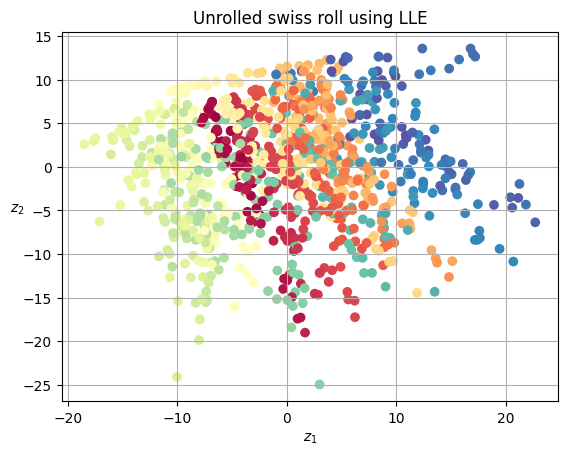

In [18]:
plt.scatter(X_unrolled[:, 0], X_unrolled[:, 1],
            c=t, cmap=plt.cm.Spectral)
plt.xlabel("$z_1$")
plt.ylabel("$z_2$", rotation=0)
plt.grid(True)
plt.title("Unrolled swiss roll using LLE")
plt.show()

Here we use LLE implementation from sklearn:

In [19]:
from sklearn.manifold import LocallyLinearEmbedding
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_unrolled = lle.fit_transform(X_swiss)

The Swiss roll is completely unrolled, and the distances between instances are locally well preserved. However, distances are not preserved on a larger scale: the unrolled Swiss roll should be a rectangle, not this kind of stretched and twisted band. Nevertheless, LLE did a pretty good job of modeling the manifold:

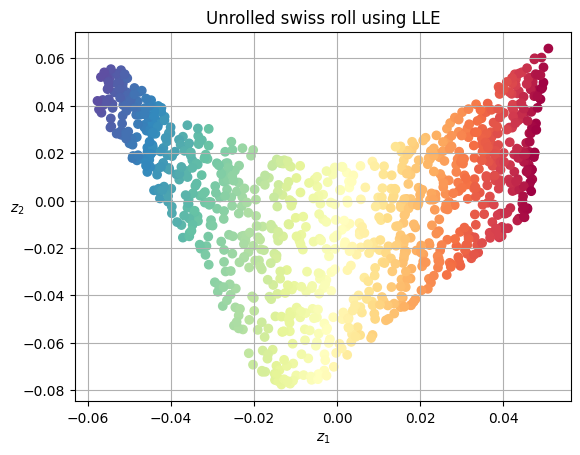

In [20]:
plt.scatter(X_unrolled[:, 0], X_unrolled[:, 1],
            c=t, cmap=plt.cm.Spectral)
plt.xlabel("$z_1$")
plt.ylabel("$z_2$", rotation=0)
plt.grid(True)

#save_fig("lle_unrolling_plot")
plt.title("Unrolled swiss roll using LLE")
plt.show()

## <font color='#D61E85' size='+3'>**Q4:**</font> <font size='+2'> **t-SNE vs. UMAP ‎️‍🔥** </font>

In this question we need the first $5000$ images of Fashion-MNIST dataset. We want to reduce the dimension of these samples down to 2 so we can plot them. Here, we use t-SNE and UMAP to perform these reductions. You can use scatterplot with 10 different colors to demonstrate the class of each instance. After visulaization try to analyze your results and compare them with each other. Is there any pattern in these visualizations?

<font color='#8FCF26' size='+2'>**A4:**</font> Your explanations

In [21]:
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 4.3 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=ae62a2b6183b0e8f057cead51f356347d3be5fee077b4a9132d23628db1730e6
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn


In [23]:
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.manifold import TSNE
from umap import UMAP
import numpy as np

In [24]:
# Your code
# Load the Fashion-MNIST dataset
fashion_mnist = fetch_openml(name='Fashion-MNIST')
X, y = fashion_mnist.data.astype('float32')/255.0, fashion_mnist.target.astype('int')

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [25]:
X_sample, y_sample = X[:5000], y[:5000]

## t-SNE

t-SNE is a probabilistic algorithm that aims to preserve both local and global structure in the data. This means that it can accurately capture the relationships between similar data points, even if they are far apart in the original high-dimensional space. However, t-SNE can be computationally expensive, especially for large datasets:

In [26]:
tsne = TSNE(n_components=2, init="random", learning_rate="auto",
            random_state=42)
X_reduced_tsne = tsne.fit_transform(X_sample)

t-SNE could distingush some of the classes accuractely but about other classes, it is obvious that we have an area that different classes are mixed up. But in overall, it had a good performance:

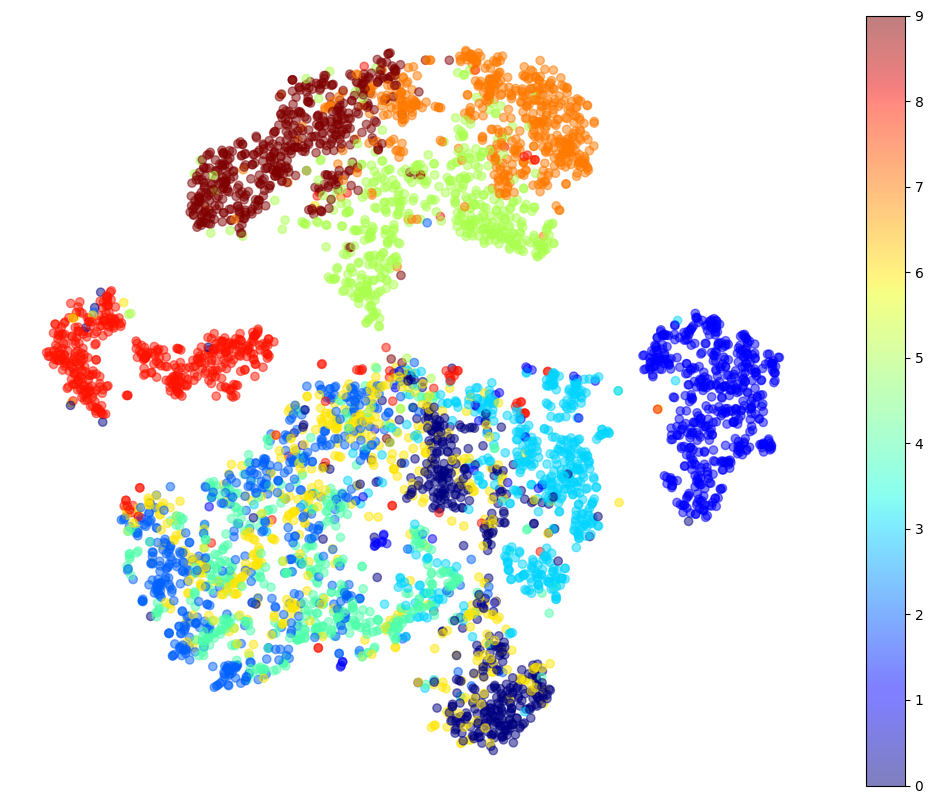

In [27]:
plt.figure(figsize=(13, 10))
plt.scatter(X_reduced_tsne[:, 0], X_reduced_tsne[:, 1],
            c=y_sample.astype(np.int8), cmap="jet", alpha=0.5)
plt.axis('off')
plt.colorbar()
plt.show()

## UMAP

UMAP is a non-linear dimensionality reduction technique that is designed to be faster and more scalable than t-SNE. It does this by using a random projection step to reduce the dimensionality of the data before applying a locally linear embedding step. This allows UMAP to preserve more of the local structure of the data, while still being able to handle large datasets:

In [28]:
u_map = UMAP(n_components=2, random_state=42)
X_reduced_umap = u_map.fit_transform(X_sample)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Despite of t-SNE, we have more concentrated areas in UMAP. In the t-SNE, we observed more scattered points. The performance of UMAP is approximately is same as t-SNE; it has recognized and separated the same classes that t-SNE distinguished them correctly and has some problem with other classes:

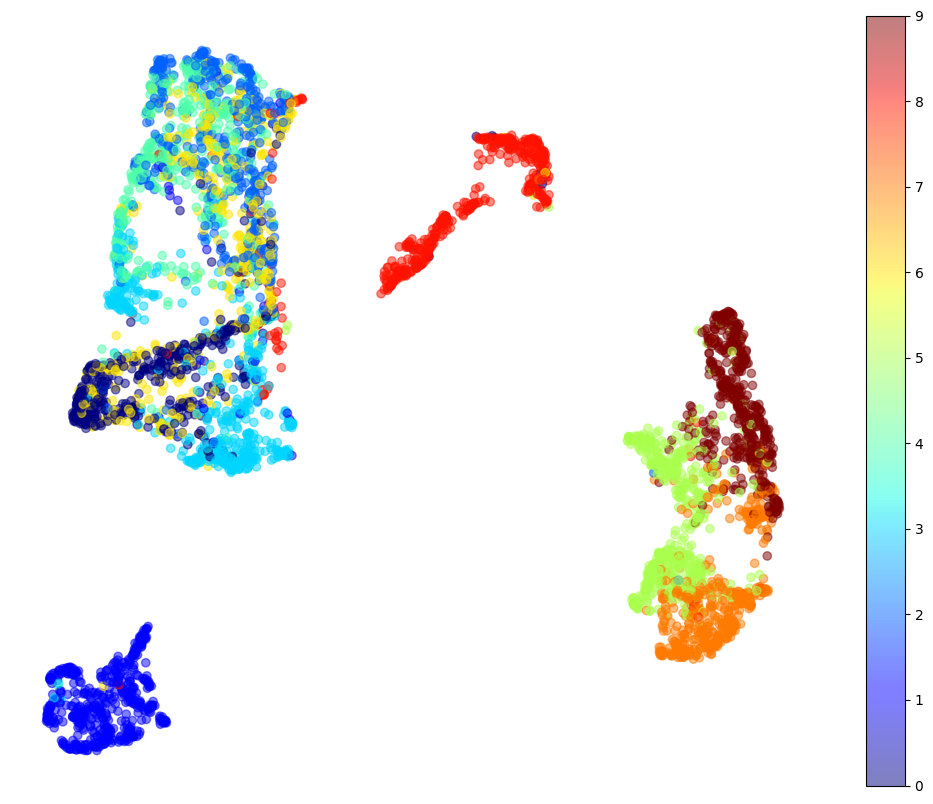

In [29]:
plt.figure(figsize=(13, 10))
plt.scatter(X_reduced_umap[:, 0], X_reduced_umap[:, 1],
            c=y_sample.astype(np.int8), cmap="jet", alpha=0.5)
plt.axis('off')
plt.colorbar()
plt.show()

Overall, the difference between the results of t-SNE and UMAP is becuase of that is the fact that t-SNE is better at preserving local structure, while UMAP is better at preserving global structure.

## <font color='#D61E85' size='+3'>**Q5:**</font> <font size='+2'> **Iris** </font>

You will take a shortcut and load the Iris dataset from Scikit-learn’s datasets module. Furthermore, you will only select two features, sepal width and petal length, to make the classification task more challenging for illustration purposes

In [104]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import KFold

In [110]:
# Your Code
# Load the Iris dataset
iris = load_iris()
X = iris.data[:, [1, 2]]  # Selecting sepal width and petal length as features
y = iris.target

We scale data at first:

In [111]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

split the Iris examples into 50 percent training and 50 percent test data:

In [112]:
# Your Code
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

Using the training dataset, you now will train three different classifiers:

- Logistic regression classifier

- Decision tree classifier

- k-nearest neighbors classifier

you will then evaluate the model performance of each classifier via 10-fold cross-validation on the training dataset before combining them into an ensemble classifier:

In [113]:
# Your Code
# Train three different classifiers
log_reg_clf = LogisticRegression(random_state=42)
tree_clf = DecisionTreeClassifier(random_state=42)
knn_clf = KNeighborsClassifier()

The results on validation and test sets are ready. We expect that making an ensemble model from these three classifiers give us a better performance than the best alone classifier:

In [114]:
# Evaluate model performance via 10-fold cross-validation
classifiers = [log_reg_clf, tree_clf, knn_clf]

for clf in classifiers:
    test_scores = []
    val_scores = []

    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    for train_index, val_index in kf.split(X_train):

        # Train the model on the training index
        clf.fit(X_train[train_index], y_train[train_index])

        # Evaluate the model on test set and validation set
        test = clf.score(X_test, y_test)
        val = clf.score(X_train[val_index], y_train[val_index])
        test_scores.append(test)
        val_scores.append(val)

    print(f"{clf.__class__.__name__}:")
    print(f"Mean Accuracy on test set: {np.array(test_scores).mean():.4f}")
    print(f"Mean Accuracy on validation set: {np.array(val_scores).mean():.4f}")
    print()

LogisticRegression:
Mean Accuracy on test set: 0.9280
Mean Accuracy on validation set: 0.8750

DecisionTreeClassifier:
Mean Accuracy on test set: 0.8733
Mean Accuracy on validation set: 0.8661

KNeighborsClassifier:
Mean Accuracy on test set: 0.9040
Mean Accuracy on validation set: 0.8750



The results of voting classifier is not what we expected. On the validation set, ensemble model performed as well as the best classifier. On the other hand, it couldn't surpass LogisticRegression performance but it is superior to DecisionTree and KNN but Why this happens?

1. **Correlated Errors:**
   If the errors made by the individual models are highly correlated, the ensemble may not perform significantly better. The idea behind ensemble learning is to reduce variance by averaging or voting over uncorrelated errors. If the errors are similar across models, this advantage diminishes.

2. **Hyperparameter Tuning:**
   The individual models may not have been fine-tuned for optimal performance, or the hyperparameters chosen might not be suitable for ensemble combination. Tuning hyperparameters specifically for the ensemble might improve its performance.

3. **Model Diversity:**
   Ensemble models tend to perform better when the base models are diverse. If all the models in your ensemble are good at the same aspects of the data but weak in others, the ensemble might not improve overall performance.

In [117]:
test_scores = []
val_scores = []

voting_clf = VotingClassifier(estimators=[
    ('log_reg', log_reg_clf),
    ('tree', tree_clf),
    ('knn', knn_clf)
], voting='hard')

kf = KFold(n_splits=10, shuffle=True, random_state=42)
for train_index, val_index in kf.split(X_train):

    # Train the model on the training index
    voting_clf.fit(X_train[train_index], y_train[train_index])

    # Evaluate the model on test set and validation set
    test = voting_clf.score(X_test, y_test)
    val = voting_clf.score(X_train[val_index], y_train[val_index])
    test_scores.append(test)
    val_scores.append(val)

print(f"Mean Accuracy on test set: {np.array(test_scores).mean():.4f}")
print(f"Mean Accuracy on validation set: {np.array(val_scores).mean():.4f}")
print()

Mean Accuracy on test set: 0.9200
Mean Accuracy on validation set: 0.8750



## <font color='#D61E85' size='+3'>**Q6:**</font> <font size='+2'> **Carseats** </font>

#### Ensemble Learning

Ensemble learning is a machine learning technique that involves combining the predictions of multiple models to improve the overall performance and accuracy of a system. Instead of relying on a single model to make predictions, ensemble methods use a group of models and aggregate their predictions to achieve better results than any individual model could achieve on its own.

The basic idea behind ensemble learning is that by combining the strengths of different models, it is possible to mitigate the weaknesses of each individual model. Ensemble methods are often used to enhance predictive accuracy, reduce overfitting, and improve the robustness of the model.

There are several popular ensemble learning techniques, including:

**Bagging (Bootstrap Aggregating):** This method involves training multiple instances of the same learning algorithm on different subsets of the training data, typically created by random sampling with replacement. The predictions of these models are then averaged or voted upon to make the final prediction.

**Boosting:** Boosting focuses on training a sequence of weak learners, where each subsequent model corrects the errors of its predecessor. Popular boosting algorithms include AdaBoost (Adaptive Boosting) and Gradient Boosting.

**Random Forest:** Random Forest is an ensemble method based on bagging. It constructs multiple decision trees during training and combines their predictions through averaging or voting. Each tree in the forest is trained on a random subset of the features.

Stacking: Stacking involves training multiple diverse models and using another model (meta-model or blender) to combine their predictions. The predictions of individual models serve as input features for the meta-model.

Ensemble learning is a powerful technique that is widely used in various machine learning applications. It is particularly effective when dealing with complex and diverse datasets, as well as when individual models may have different strengths and weaknesses.

We are going to work with **Carseats** dataset. We want to predict the sales using regression trees and related approaches, treating the response as a quantitative variable.

- Load Dataset

In [80]:
import pandas as pd
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, export_graphviz

In [61]:
path = "/content/Carseats.csv"
df = pd.read_csv(path)
df.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


No null value

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Sales        400 non-null    float64
 1   CompPrice    400 non-null    int64  
 2   Income       400 non-null    int64  
 3   Advertising  400 non-null    int64  
 4   Population   400 non-null    int64  
 5   Price        400 non-null    int64  
 6   ShelveLoc    400 non-null    object 
 7   Age          400 non-null    int64  
 8   Education    400 non-null    int64  
 9   Urban        400 non-null    object 
 10  US           400 non-null    object 
dtypes: float64(1), int64(7), object(3)
memory usage: 34.5+ KB


- Do preprocess
- Split the data set into a training set and a test set.

In [63]:
X = df.drop('Sales', axis=1)
y = df['Sales']

At first, we scale numerical columns using StandardScaler:

In [64]:
scaler = StandardScaler()
numerical_columns = X.select_dtypes(include=np.number).columns
X[numerical_columns] = scaler.fit_transform(X[numerical_columns])

We have some categorical columns that we should convert them to numerical values. One-hot encoding can be applied to these columns beucase they don't have many unique values:

In [65]:
# Your Code:
cat_df = X.select_dtypes(include='object')
cat_df.head()

,ShelveLoc,Urban,US
0,Bad,Yes,Yes
1,Good,Yes,Yes
2,Medium,Yes,Yes
3,Medium,Yes,Yes
4,Bad,Yes,No


In [66]:
encoded_df = pd.get_dummies(X, columns = ['ShelveLoc', 'Urban', 'US'])
encoded_df.head()

,CompPrice,Income,Advertising,Population,Price,Age,Education,ShelveLoc_Bad,ShelveLoc_Good,ShelveLoc_Medium,Urban_No,Urban_Yes,US_No,US_Yes
0,0.850455,0.155361,0.657177,0.075819,0.177823,-0.699782,1.184449,1,0,0,0,1,0,1
1,-0.912484,-0.739060,1.409957,-0.032882,-1.386854,0.721723,-1.490113,0,1,0,0,1,0,1
2,-0.781896,-1.204159,0.506621,0.028262,-1.513719,0.350895,-0.725953,0,0,1,0,1,0,1
3,-0.520720,1.121336,-0.396715,1.366649,-0.794814,0.103677,0.038208,0,0,1,0,1,0,1
4,1.046337,-0.166631,-0.547271,0.510625,0.516132,-0.947000,-0.343872,1,0,0,0,1,1,0


In [69]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(encoded_df, y, test_size=0.2, random_state=42)

- Fit a regression tree to the training set. Plot the tree, and interpret
the results. What test MSE do you obtain?

We see a huge tree and it's hard to explain it in details but at the top of tree, ShelveLoc is the feature that starts tree and then we see features like Age, Price and Income. The value of MSE on the test set is 5.39:

MSE on the test set: 5.397617500000001


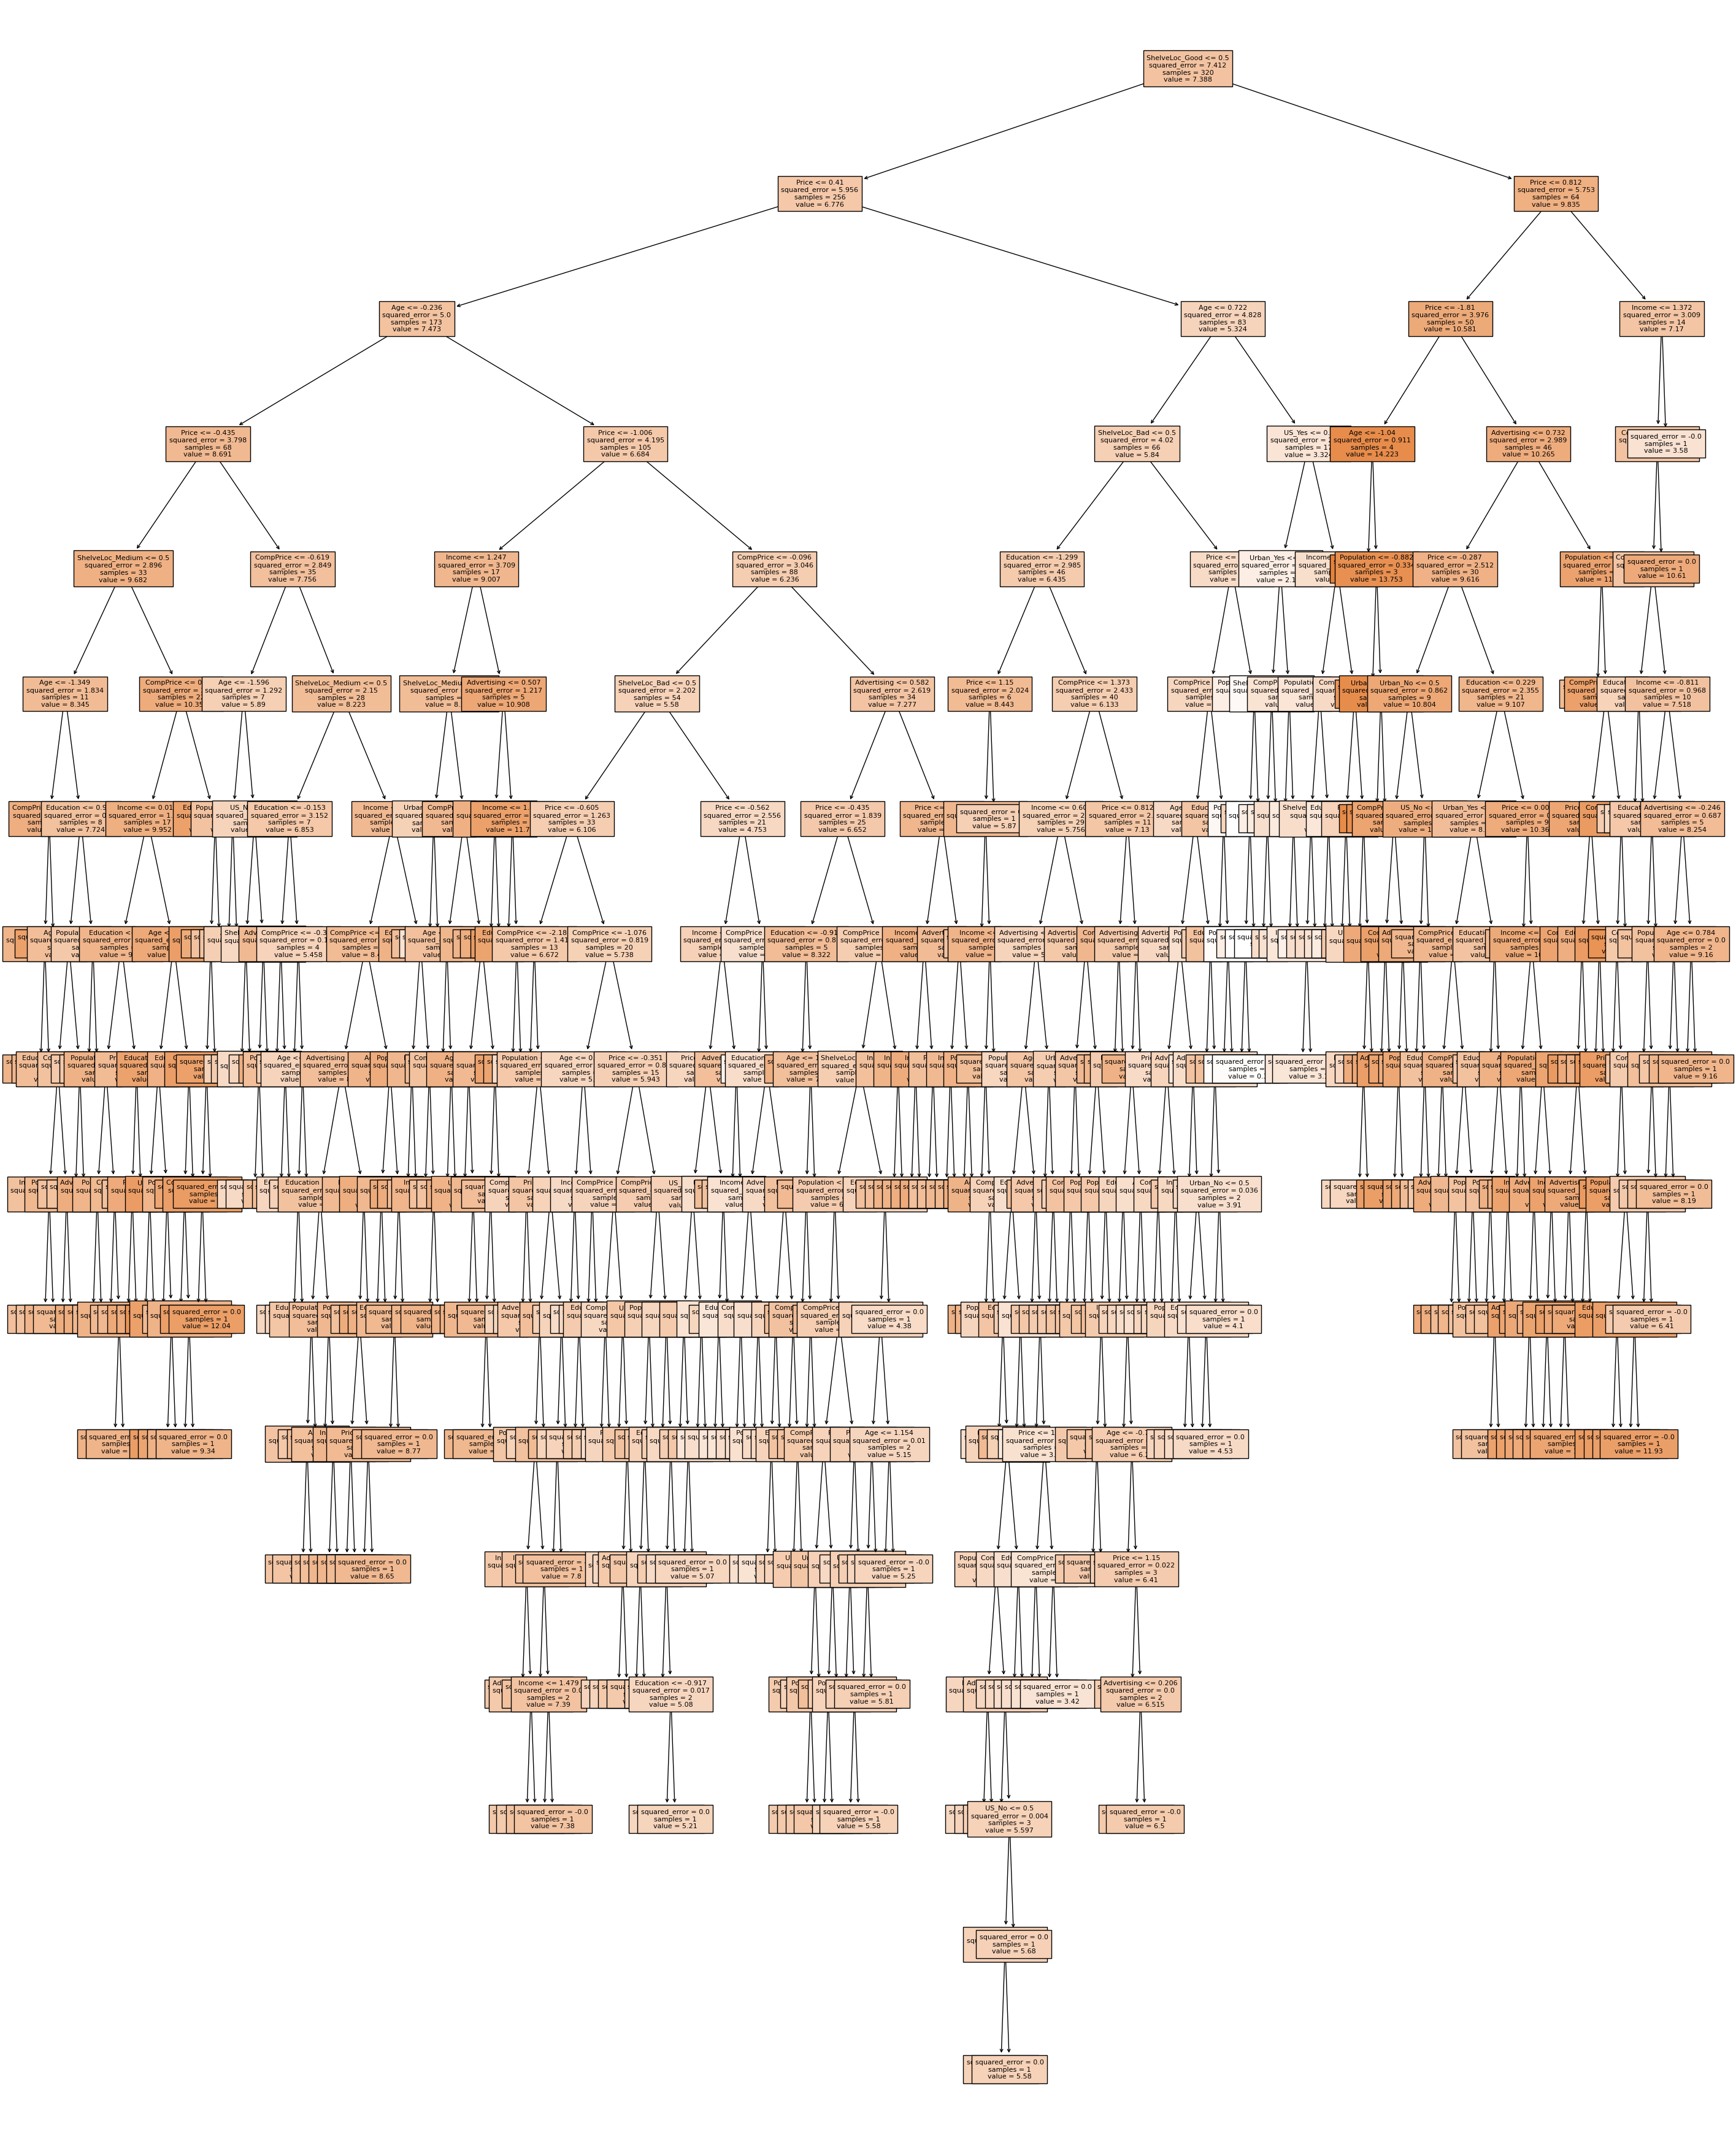

In [78]:
# Your code
# Fit a regression tree to the training set
reg_tree = DecisionTreeRegressor(random_state=42)
reg_tree.fit(X_train, y_train)

# Calculate the test mean squared error
y_pred = reg_tree.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('MSE on the test set:', mse)

# Plot the tree
plt.figure(figsize=(35,45))
plot_tree(reg_tree, feature_names=encoded_df.columns, filled=True, fontsize=8)
plt.show()

- Use the bagging approach in order to analyze this data. What test MSE do you obtain? which variables are most important. visualize them

According to MSE we have better results with BaggingRegressor becuase it has reduced from 5.39 to 3.18:

In [84]:
# Your code
# Use the bagging approach
bag_reg = BaggingRegressor(DecisionTreeRegressor(random_state=42), random_state=42)
bag_reg.fit(X_train, y_train)

y_pred = bag_reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('Bagging MSE on the test set:', mse)

Bagging MSE on the test set: 3.1867224125


To find the importance of each feature in the bagging classifier, we take mean of each feature importance across all of the estimators.

Among all of the features, "Price", "ShelveLoc_Good" and "Age" have more importance:

Feature Importance (Bagging):
CompPrice: 0.0872
Income: 0.0451
Advertising: 0.1087
Population: 0.0355
Price: 0.3039
Age: 0.1151
Education: 0.0366
ShelveLoc_Bad: 0.0798
ShelveLoc_Good: 0.1521
ShelveLoc_Medium: 0.0247
Urban_No: 0.0022
Urban_Yes: 0.0049
US_No: 0.0023
US_Yes: 0.0019


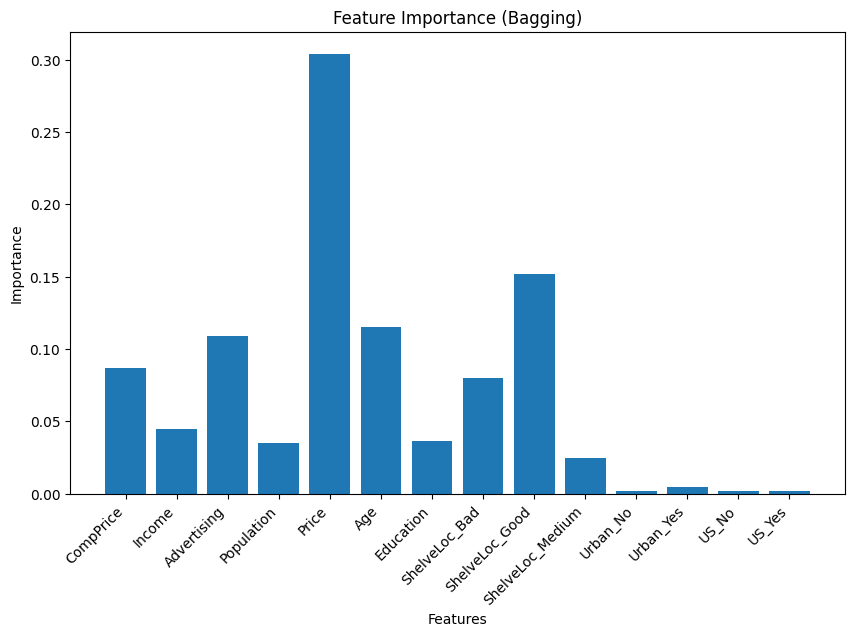

In [87]:
# Print feature importance for the bagging model
feature_importance_bagging = np.mean([tree.feature_importances_ for tree in bag_reg.estimators_], axis=0)
print("Feature Importance (Bagging):")
for feature, importance in zip(encoded_df.columns, feature_importance_bagging):
    print(f"{feature}: {importance:.4f}")

# Visualize feature importance for the bagging model
plt.figure(figsize=(10, 6))
plt.bar(encoded_df.columns, feature_importance_bagging)
plt.xticks(rotation=45, ha="right")
plt.title("Feature Importance (Bagging)")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()

- Use random forests to analyze this data. What test MSE do you obtain?  which variables are most important. Describe the effect of m, the number of variables considered at each split, on the error rate obtained.

The value of MSE has reduced a little comparing with Bagging model but it's not too much:

In [88]:
# Your code
# Use random forests
forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(X_train, y_train)

y_pred = forest_reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('RandomForestRegressor MSE on the test set:', mse)

RandomForestRegressor MSE on the test set: 3.057048274624999


Same as Bagging Regressor, "Price", "ShelveLoc_Good" and "Age" are top 3 in feature importance:

Feature Importance (Random Forests):
CompPrice: 0.0904
Income: 0.0514
Advertising: 0.0854
Population: 0.0381
Price: 0.3034
Age: 0.1213
Education: 0.0298
ShelveLoc_Bad: 0.0667
ShelveLoc_Good: 0.1692
ShelveLoc_Medium: 0.0312
Urban_No: 0.0034
Urban_Yes: 0.0045
US_No: 0.0031
US_Yes: 0.0020


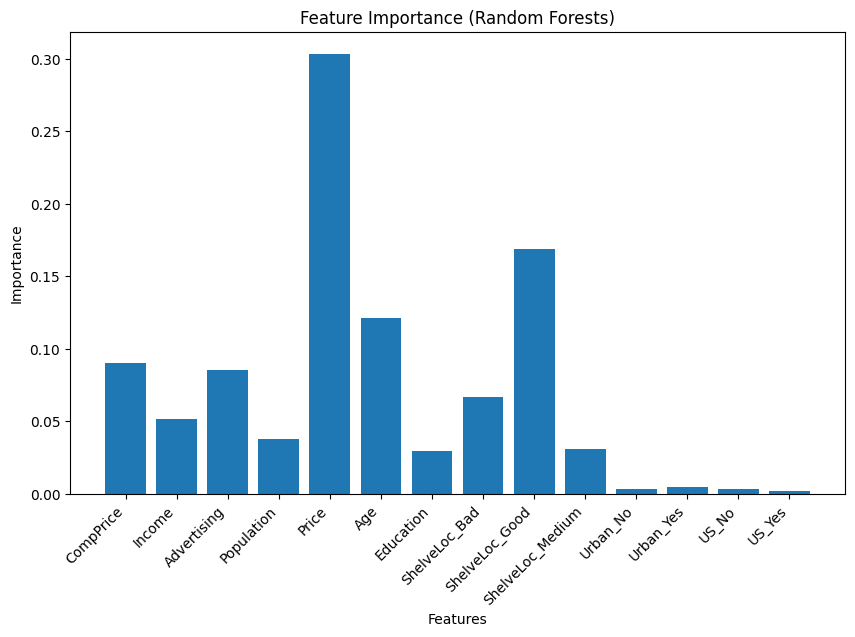

In [91]:
# Print feature importance for random forests
feature_importance_rf = forest_reg.feature_importances_
print("Feature Importance (Random Forests):")
for feature, importance in zip(encoded_df.columns, feature_importance_rf):
    print(f"{feature}: {importance:.4f}")

# Visualize feature importance for random forests
plt.figure(figsize=(10, 6))
plt.bar(encoded_df.columns, feature_importance_rf)
plt.xticks(rotation=45, ha="right")
plt.title("Feature Importance (Random Forests)")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()

Increasing max features to the some point will reduce the MSE; because using more features can increase the overall performance of the model by allowing the trees to consider more information.

But after some point, MSE will increase again. It happens due to overfitting. Using too much faetures will increase model variance which will lead to overfitting:

In [94]:
# Evaluate the effect of max features
for m in range(1, 14):
    rf_reg = RandomForestRegressor(max_features=m, random_state=42)
    rf_reg.fit(X_train, y_train)

    y_pred = rf_reg.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print('MSE (m=%i):' % m, mse)

MSE (m=1): 5.156145761125
MSE (m=2): 4.30980080125
MSE (m=3): 3.944823387124997
MSE (m=4): 3.5696213936249963
MSE (m=5): 3.3328475537499984
MSE (m=6): 3.2641361277500005
MSE (m=7): 3.259189619499999
MSE (m=8): 3.2417997470000004
MSE (m=9): 3.171248570374998
MSE (m=10): 2.9789891767500007
MSE (m=11): 3.0120298854999996
MSE (m=12): 3.178475860374998
MSE (m=13): 3.117361601374999
